In [1]:
import numpy as np # Работа с алгеброй
import pandas as pd # Обработка данных

# Визуализация
import matplotlib.pyplot as plt

# ML
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import metrics
import tensorflow as tf

# System
import os

In [2]:
data = np.load("dataset/olivetti_faces.npy")
target = np.load("dataset/olivetti_faces_target_1801_60d48f_148506_10e2e8_148506_28d650.npy")

In [3]:
print("There are {} images in the dataset".format(len(data)))
print("There are {} unique targets in the dataset".format(len(np.unique(target))))
print("Size of each image is {}x{}".format(data.shape[1],data.shape[2]))
print("Pixel values were scaled to [0,1] interval. e.g:{}".format(data[0][0,:4]))

There are 400 images in the dataset
There are 40 unique targets in the dataset
Size of each image is 64x64
Pixel values were scaled to [0,1] interval. e.g:[0.30991736 0.3677686  0.41735536 0.44214877]


In [4]:
def show_40_distinct_people(images, unique_ids):
    #Creating 4X10 subplots in  18x9 figure size
    fig, axarr = plt.subplots(nrows=4, ncols=10, figsize=(18, 9))
    #For easy iteration flattened 4X10 subplots matrix to 40 array
    axarr=axarr.flatten()
    
    #iterating over user ids
    for unique_id in unique_ids:
        image_index = unique_id * 10
        axarr[unique_id].imshow(images[image_index], cmap='gray')
        axarr[unique_id].set_xticks([])
        axarr[unique_id].set_yticks([])
        axarr[unique_id].set_title("face id:{}".format(unique_id))
    plt.suptitle("There are 40 distinct people in the dataset")

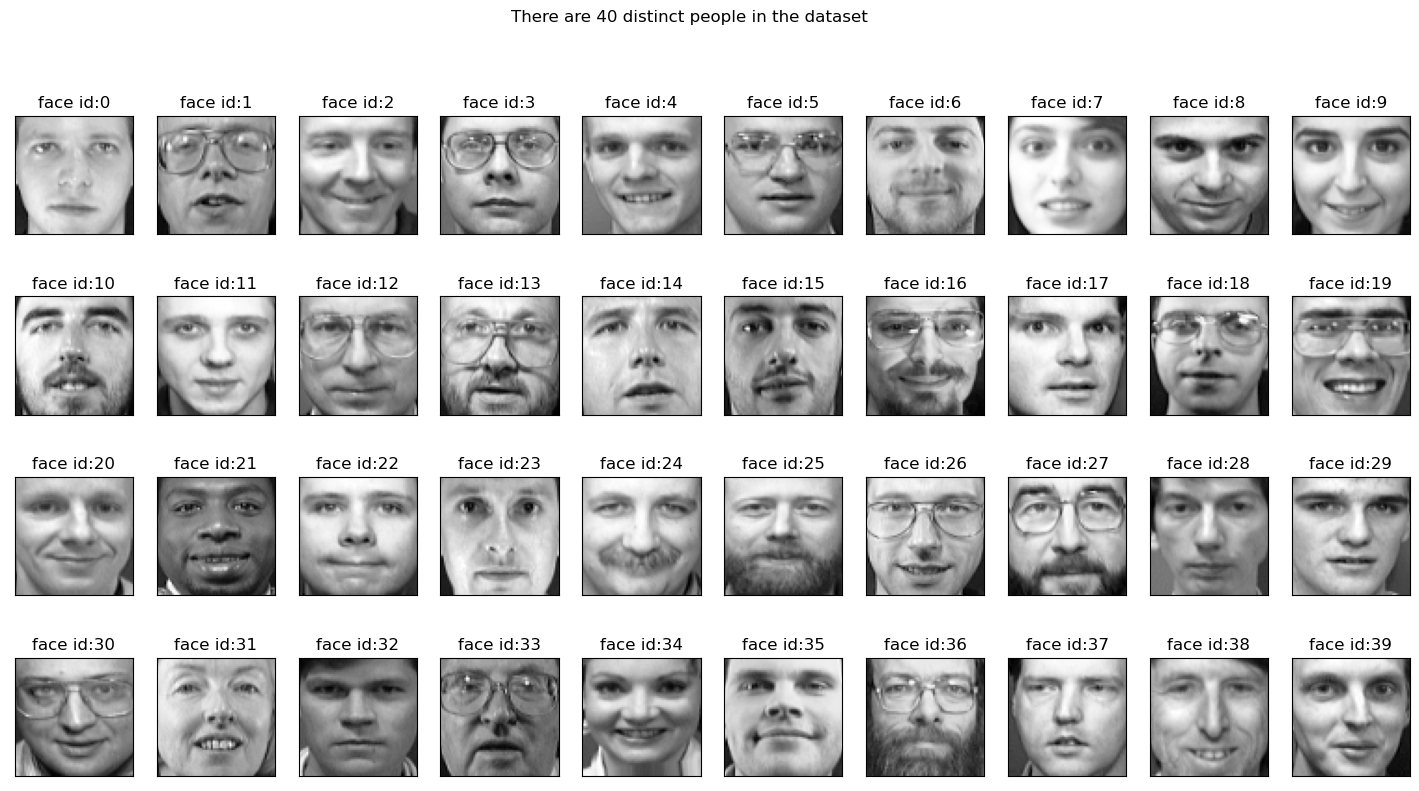

In [5]:
show_40_distinct_people(data, np.unique(target))

In [6]:
def show_10_faces_of_n_subject(images, subject_ids):
    cols = 10 # each subject has 10 distinct face images
    rows = (len(subject_ids) * 10) / cols #
    rows = int(rows)
    
    fig, axarr = plt.subplots(nrows=rows, ncols=cols, figsize=(18,9))
    
    for i, subject_id in enumerate(subject_ids):
        for j in range(cols):
            image_index=subject_id * 10 + j
            axarr[i,j].imshow(images[image_index], cmap="gray")
            axarr[i,j].set_xticks([])
            axarr[i,j].set_yticks([])
            axarr[i,j].set_title("face id:{}".format(subject_id))
    

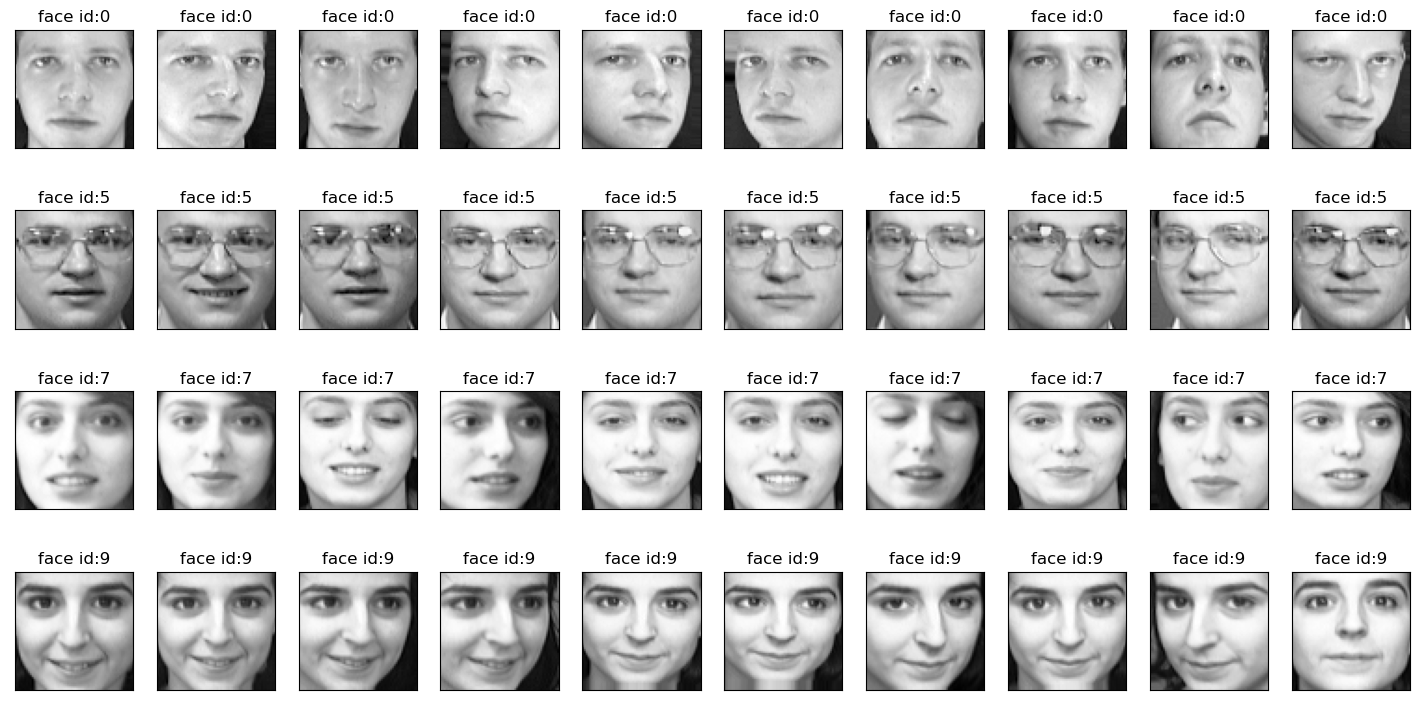

In [7]:
show_10_faces_of_n_subject(images=data, subject_ids=[0, 5, 7, 9])

In [8]:
#X = data.reshape((data.shape[0], data.shape[1] * data.shape[2]))
#print("X shape:", X.shape)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, stratify=target, random_state=0)
print("Image shape:", X_train[1].shape)
print("X_train shape:", X_train.shape)
print("y_train shape:{}".format(y_train.shape))

Image shape: (64, 64)
X_train shape: (280, 64, 64)
y_train shape:(280,)


In [13]:
from tensorflow.keras import datasets, layers, models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(40))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 64)        36928     
                                                                 
 flatten_1 (Flatten)         (None, 9216)             

In [14]:
from tqdm import trange
from time import sleep

model.compile(optimizer='adam', 
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

t = trange(20, leave=True)

fit_history = []

for key, i in enumerate(t):
    fit_history.append(model.fit(X_train, y_train, 
                             epochs=1, 
                             validation_data=(X_test, y_test), 
                             verbose=0))
    
    current_loss = round(fit_history[key].history['accuracy'][0], 3)
    current_val_loss = round(fit_history[key].history['val_accuracy'][0], 3)
    
    t.set_description(f'accuracy: {str(current_loss)}; val_accuracy:{str(current_val_loss)}')
    
    t.refresh() # to show immediately the update

accuracy: 0.95; val_accuracy:0.842: 100%|██████████| 20/20 [00:11<00:00,  1.76it/s] 


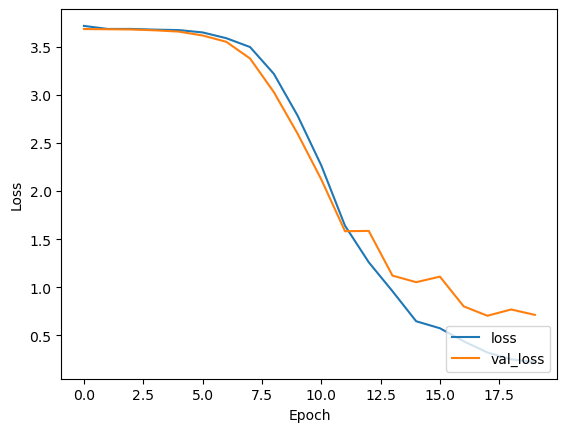

In [15]:
plt.plot([i.history['loss'] for i in fit_history], label='loss')
plt.plot([i.history['val_loss'] for i in fit_history], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend(loc='lower right')